In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap as cmap
import pygbrowse

import scanpy as sc
import scvelo as scv
from sklearn.neighbors import NearestNeighbors
from harmony import harmonize

from scipy import stats
from tqdm.notebook import tqdm
import ipywidgets
from scipy.ndimage import gaussian_filter

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu 

### Plot settings

In [2]:
COLORS = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# presentation style
plt.matplotlib.rcParams['font.weight'] = 'normal'
plt.matplotlib.rcParams['axes.titleweight'] = 'normal'
plt.matplotlib.rcParams['axes.facecolor'] = plt.matplotlib.colors.to_hex((1., 1., 1., 1.), keep_alpha=True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = .25

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

OUTDIR = '/Users/prullens/Documents/manuscripts/invivo/figure2/'

### Global variables

In [3]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]

CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5'

chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(int).to_dict()

DAMIDFN_BASE = '/Users/prullens/Documents/projects/invivo/experiments/{}/hdf5/{}.index{:02d}.DamID2_BC_{:03d}.top_n_2.event_counts.binsize_{}.hdf5'

### Data

In [4]:
gtf = pd.read_csv('/Users/prullens/metadata/mm10.Mus_musculus.GRCm38.89.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_id')

_pygBrowse_

In [5]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_Scanpy_

In [6]:
adata = sc.read_h5ad('/Users/prullens/data/projects/invivo/singlecell_lads_mouse_cortex.h5ad.gz')

adata

AnnData object with n_obs × n_vars = 5612 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    uns: 'cell_type_colors', 'construct_colors', 'construct_flattened_colors', 'embryo_colors', 'iue_colors', 'leiden_colors', 'limsid_colors', 'neighbors', 'rank_genes_groups', 'rank_genes_groups_cell_type'
    obsm: 'X_pca_harmony', 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'damid', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distanc

_DamID_

In [7]:
binsize = 10_000

In [8]:
hdf5_list = [DAMIDFN_BASE.format(limsid,limsid,int(i),int(bc),binsize) 
             for limsid,i,bc in adata.obs[(adata.obs['damid'] == True) & 
                                          (adata.obs['construct_flattened'] == 'Dam-LMNB1')][
                 ['limsid','indexnr','damid2_barcodenr']].values
]

len(hdf5_list)

2423

In [9]:
counts_10kb, depths = scct.load_counts(hdf5_list, binsize, CHROMSIZES, chroms=CHROMS)

  0%|          | 0/2423 [00:00<?, ?it/s]

In [11]:
rebinsize = 50_000

counts_rebin = scct.rebinning(counts_10kb, binsize, rebinsize, chroms=CHROMS, disable_tqdm=False)

  0%|          | 0/2423 [00:00<?, ?it/s]

In [14]:
expected, _ = scct.load_counts([EXPECTED %binsize], binsize, CHROMSIZES, chroms=CHROMS, disable_tqdm=True)
expected_rebin = scct.rebinning(expected, binsize, rebinsize, chroms=CHROMS)
expected_rebin = expected_rebin[list(expected)[0]]

In [15]:
oe_rebin, depths = scct.compute_oe(counts_rebin, 
                             rebinsize, 
                             CHROMSIZES, 
                             depth_thrs=1_000, 
                             expected=expected_rebin, 
                             blacklist=BLACKLIST, 
                             chroms=CHROMS
)
len(oe_rebin)

  0%|          | 0/2423 [00:00<?, ?it/s]

2423

In [16]:
smooth_stddev = 75_000

oe_rebin_smooth = scct.gaussian_smoothing(oe_rebin, rebinsize, smooth_stddev, disable_tqdm=False)

  0%|          | 0/2423 [00:00<?, ?it/s]

_dyn-i/LAD genes_

In [17]:
gene_class = pd.read_csv('/Users/prullens/Documents/projects/invivo/PR20241108.ilad_lad_genes_activating_deactivating_balanced.tsv', sep='\t')

gene_class.shape

(677, 6)

### Plot

In [18]:
adata.uns['cell_type_colors'] = np.array(['#1B7837', #PN1
                                          '#00441B',#PN2
                                          '#053061', #apical_progenitors
                                       '#4393C3', #intermediate_progenitors
                                       '#2020DF', #interneurons
                                       '#AFA5CF', #migrating_neurons
                                       '#543005'], #red_blood_cells
                                      dtype=object
)

In [19]:
cell_type_colors = dict(zip(adata.obs['cell_type'].cat.categories,adata.uns['cell_type_colors']))

cell_type_colors

{'PN1': '#1B7837',
 'PN2': '#00441B',
 'apical_progenitors': '#053061',
 'intermediate_progenitors': '#4393C3',
 'interneurons': '#2020DF',
 'migrating_neurons': '#AFA5CF',
 'red_blood_cells': '#543005'}

In [20]:
cell_types = ['apical_progenitors','intermediate_progenitors','migrating_neurons','PN1','PN2']

cell_types

['apical_progenitors',
 'intermediate_progenitors',
 'migrating_neurons',
 'PN1',
 'PN2']

### Trajectory inference (Monocle 3)

Text(0.5, 1.0, 'monocle_pseudotime')

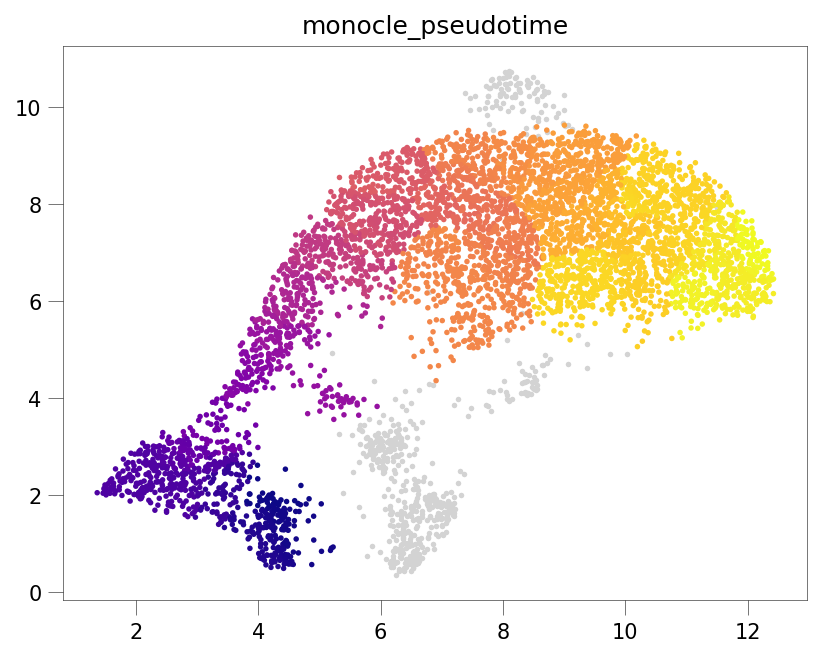

In [21]:
X, y = adata.obsm['X_umap'].T
idx = ~adata.obs['monocle_pseudotime'].isna()

f, ax = plt.subplots()

ax.scatter(X[~idx], 
           y[~idx],
           s=7,
           lw=0,
           color='lightgrey',
)

ax.scatter(X[idx], 
           y[idx], 
           c=adata.obs['monocle_pseudotime'][idx],
           cmap='plasma',
           s=7,
           lw=0)

ax.set_title(idx.name)

____

### dyn-i/LAD genes

In [26]:
var_names = gene_class['Gene'].values

var_names.size

677

In [27]:
df = pd.DataFrame({'iLAD_deact':((gene_class['class'] == 'iLAD') & (gene_class['trend'] == 'deactivating')).sum(),
                   'iLAD_act':((gene_class['class'] == 'iLAD') & (gene_class['trend'] == 'activating')).sum(),
                   'LAD_deact':((gene_class['class'] == 'LAD') & (gene_class['trend'] == 'deactivating')).sum(),
                   'LAD_act':((gene_class['class'] == 'LAD') & (gene_class['trend'] == 'activating')).sum()
                  }, index=[0]
)

df.shape

(1, 4)

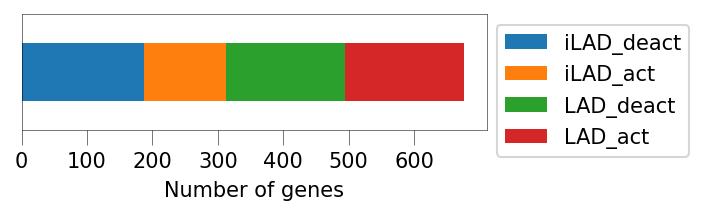

In [28]:
f, ax = plt.subplots(figsize=(4,1), 
)
df.plot(kind='barh', 
        stacked=True, 
        ax=ax
)
ax.set_yticks([])
ax.set_xticks(np.arange(0,var_names.size,100))
ax.set_xlabel('Number of genes')
ax.legend(bbox_to_anchor=(1,1))

___

### GO-analysis

In [29]:
go_lad = pd.read_csv('/Users/prullens/Documents/projects/invivo/experiments/GO_analysis/PR20241030.go_analysis_lad_genes_monocleq_activating_5_deactivating_40_n364.txt', sep='\t', skiprows=11)
go_nonlad = pd.read_csv('/Users/prullens/Documents/projects/invivo/experiments/GO_analysis/PR20240802.go_analysis.non_lad.n264.txt', sep='\t', skiprows=11)

go_lad.shape, go_nonlad.shape

((902, 8), (437, 8))

In [30]:
columns = ['GO biological process complete','upload_1 (353)','upload_1 (fold Enrichment)','upload_1 (raw P-value)']
go_lad_processed = go_lad[columns].copy()

new_columns = ['GO Term','Gene Count','Fold Enriched','p-value']
go_lad_processed.columns = new_columns
go_lad_processed['GO Accession'] = go_lad_processed['GO Term'].str.split('(').str[-1].str.strip(')')
go_lad_processed['GO Term'] = go_lad_processed['GO Term'].str.split('(').str[0]

In [31]:
columns = ['GO biological process complete','upload_1 (179)','upload_1 (fold Enrichment)','upload_1 (raw P-value)']
go_nonlad_processed = go_nonlad[columns].copy()

new_columns = ['GO Term','Gene Count','Fold Enriched','p-value']
go_nonlad_processed.columns = new_columns
go_nonlad_processed['GO Accession'] = go_nonlad_processed['GO Term'].str.split('(').str[-1].str.strip(')')
go_nonlad_processed['GO Term'] = go_nonlad_processed['GO Term'].str.split('(').str[0]

In [32]:
topn = 5

columns = ['GO biological process complete','upload_1 (raw P-value)','upload_1 (fold Enrichment)']

go_lad_sub = go_lad[columns + [go_lad.columns[2]]].head(topn)
go_nonlad_sub = go_nonlad[columns + [go_nonlad.columns[2]]].head(topn)

____

Text(0.5, 1.0, 'dyn-iLAD')

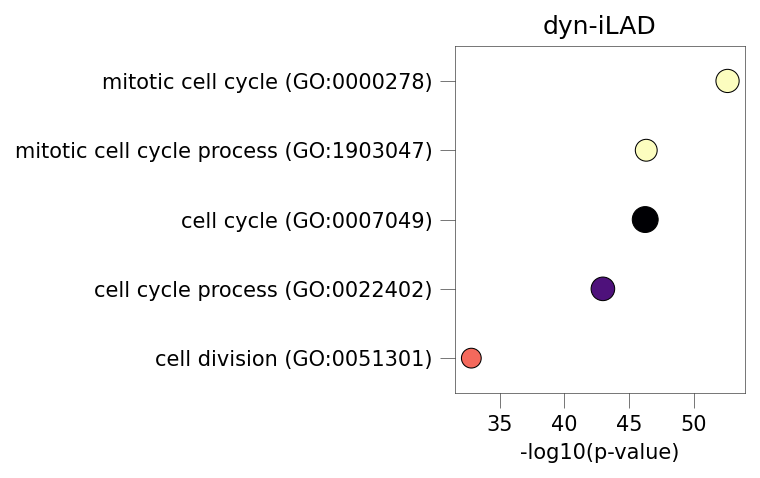

In [34]:
cmap_loc = cmap.from_list('',('red','blue'))

x = -np.log10(go_nonlad_sub['upload_1 (raw P-value)'])
y = go_nonlad_sub['GO biological process complete']
s = go_nonlad_sub.iloc[:,-1] * 2
c = go_nonlad_sub['upload_1 (fold Enrichment)'].astype(float)

f, ax = plt.subplots(figsize=(2.5,3))


ax.scatter(x, y, s=s, lw=.5, edgecolor='k', c=c, cmap='magma', vmin=8, vmax=12)

ax.set_ylim(-.5,4.5)
ax.set_xlim(31.5,54)
ax.set_xticks([35,40,45,50])
ax.invert_yaxis()
ax.set_xlabel('-log10(p-value)')
ax.set_title('dyn-iLAD')

Text(0.5, 1.0, 'dyn-LAD')

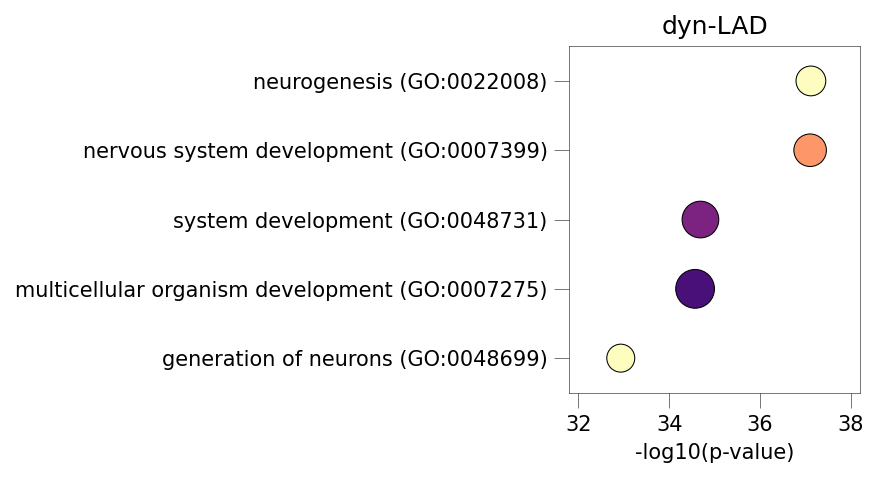

In [35]:
cmap_loc = cmap.from_list('',('blue','red'))

x = -np.log10(go_lad_sub['upload_1 (raw P-value)'])
y = go_lad_sub['GO biological process complete']
s = go_lad_sub.iloc[:,-1] * 2
c = go_lad_sub['upload_1 (fold Enrichment)'].astype(float)

f, ax = plt.subplots(figsize=(2.5,3))

ax.scatter(x, y, s=s, lw=.5, edgecolor='k', c=c, cmap='magma', vmin=2, vmax=4)

ax.set_ylim(-.5,4.5)
ax.set_xlim(31.8,38.2)
ax.invert_yaxis()
ax.set_xlabel('-log10(p-value)')
ax.set_title('dyn-LAD')

___

### Cell type-specific LADs

In [54]:
cf_dict = dict()
for cell_type in cell_types:
    obs_names = adata.obs[np.ravel(adata.obs['damid']) &
                (adata.obs['cell_type'] == cell_type) & 
                (adata.obs['construct_flattened'] == 'Dam-LMNB1')].index
    cf_dict[cell_type] = {c: np.mean([oe_rebin_smooth[obs][c] > 1 for obs in obs_names], axis=0) for c in CHROMS}
    print(cell_type)

apical_progenitors
intermediate_progenitors
migrating_neurons
PN1
PN2


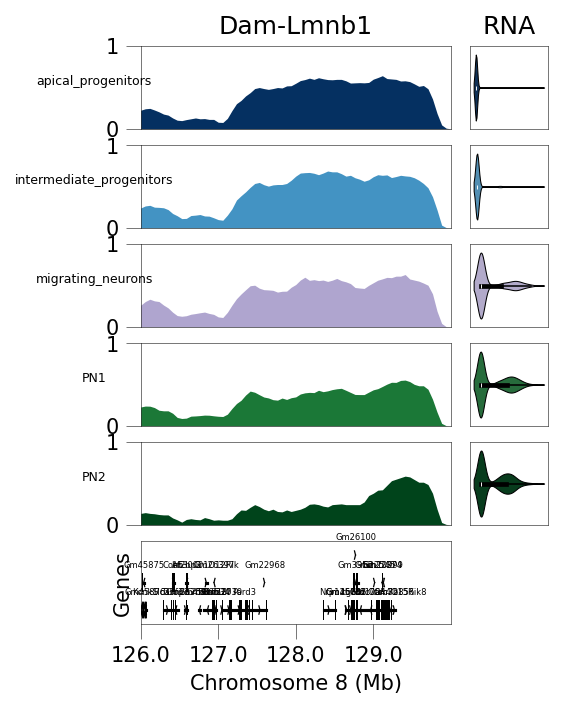

In [55]:
var = 'Nrp1'

chrom = '8'
s = 126_000_000 #Nrp1
e = 130_000_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize]

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,1)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()

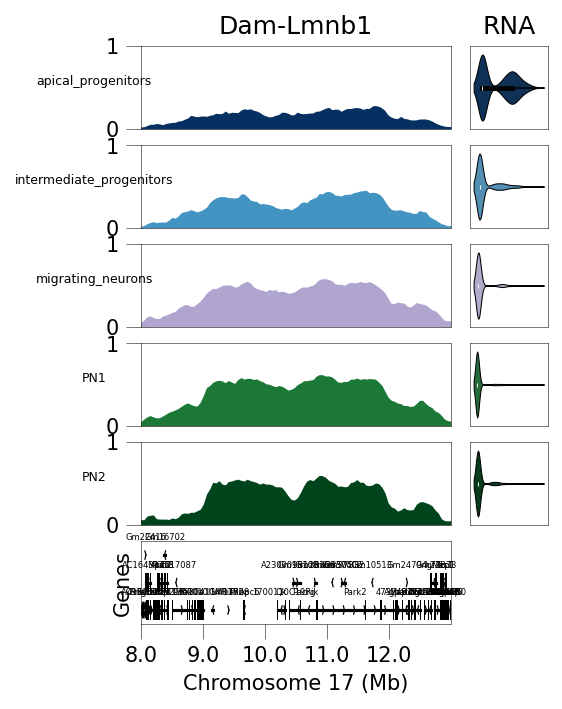

In [56]:
var = 'Qk'

chrom = '17'
s = 8_000_000 #Qk
e = 13_000_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = gaussian_filter(cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize], sigma=0)

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,1)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    #ax[i,1].set_xlim(right=1.5)

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()

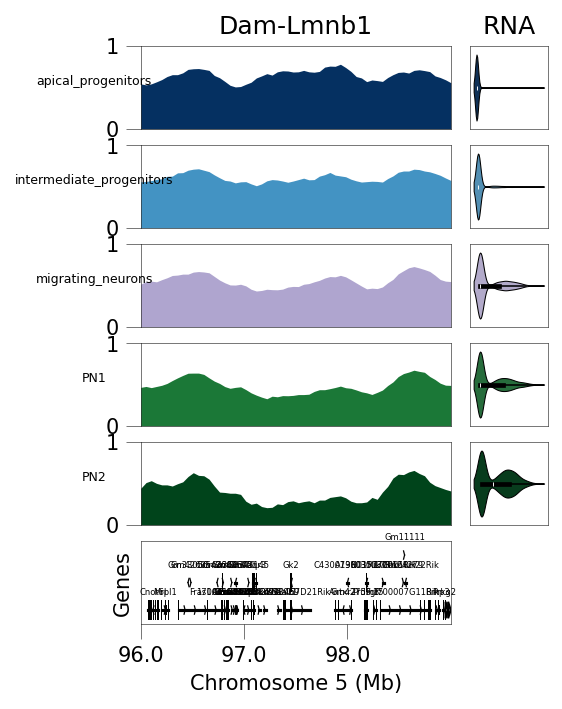

In [57]:
var = 'Prdm8'

chrom = '5'
s = 96_000_000 #Prdm8
e = 99_000_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize]

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,1)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()

orphan transcript transcript:ENSMUST00000160520 with missing parent gene:ENSMUSG00000089645!
orphan transcript transcript:ENSMUST00000090457 with missing parent gene:ENSMUSG00000022543!
orphan transcript transcript:ENSMUST00000231040 with missing parent gene:ENSMUSG00000022543!
orphan transcript transcript:ENSMUST00000231077 with missing parent gene:ENSMUSG00000022543!
orphan transcript transcript:ENSMUST00000229605 with missing parent gene:ENSMUSG00000022543!


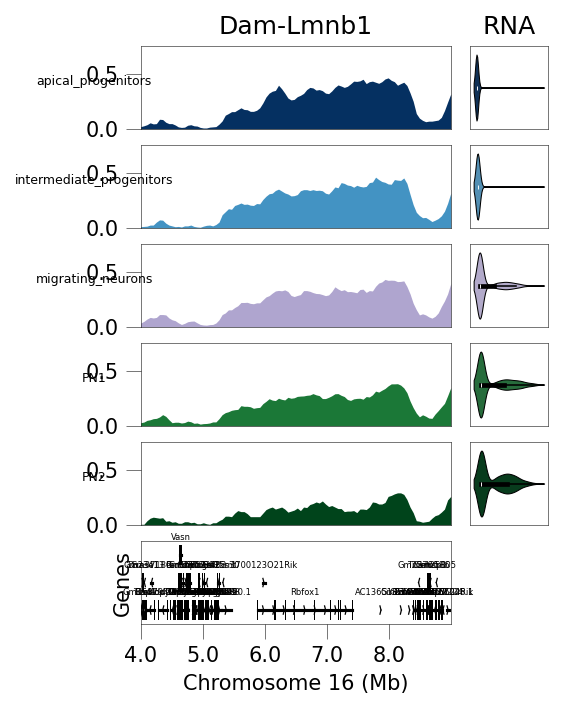

In [58]:
var = 'Rbfox1'

chrom = '16'
s = 4_000_000 #Rbfox1
e = 9_000_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = gaussian_filter(cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize], sigma=0)

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,.75)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    #ax[i,1].set_xlim(right=1.5)

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()

#plt.savefig(OUTDIR + f"damlb1_{var}_locus_cell_types.pdf", bbox_inches='tight')

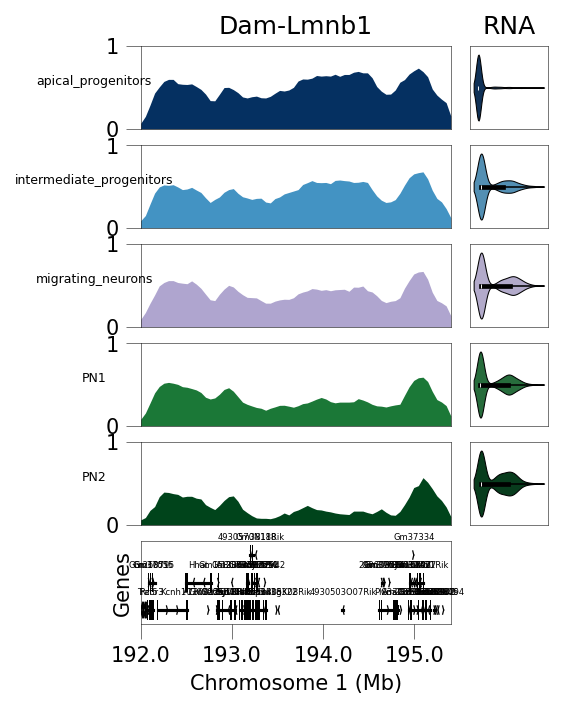

In [59]:
var = 'Plxna2'

chrom = '1'
s = 192_000_000 #Plxna2
e = 195_400_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize]

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,1)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()

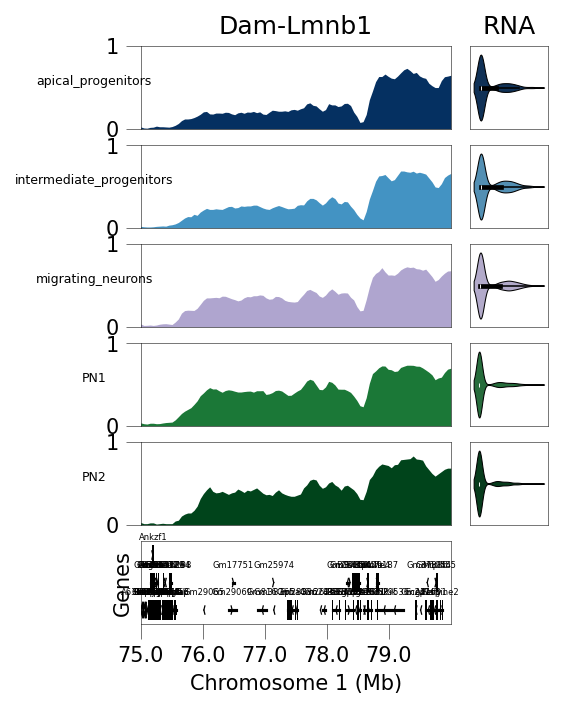

In [60]:
var = 'Epha4'

chrom = '1'
s = 75_000_000 #Epha4
e = 80_000_000

xaxis = np.arange(0,chromsizes[chrom],rebinsize)

f, ax = plt.subplots(len(cell_types) + 1, 
                     2, 
                     figsize=(3.5,5), 
                     gridspec_kw={'width_ratios':[.8,.2],'wspace':.1}
)

for i,cell_type in enumerate(cell_types):
    X = np.ravel(adata[adata.obs['cell_type'] == cell_type,var].layers['count_abundance_genes_from_celseq2_data'].toarray())
    x = xaxis[s//rebinsize:e//rebinsize]
    y = cf_dict[cell_type][chrom][s//rebinsize:e//rebinsize]

    ax[i,0].fill_between(x, 
                       y, 
                       color=cell_type_colors[cell_type], 
                       lw=0
    )
    sns.violinplot(x=X, 
                   color=cell_type_colors[cell_type], 
                   edgecolor='k',
                   linewidth=.5,
                   ax=ax[i,1]
    )
    
    ax[i,0].set_ylabel(cell_type, fontsize=6, rotation=0)
    ax[i,0].yaxis.set_label_coords(-0.15, 0.5)
    ax[i,0].set_ylim(0,1)
    ax[i,0].margins(x=0)
    ax[i,0].set_xticks(np.arange(s,e,1_000_000))
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])

genemodel_plotter.plot(ax[-1,0], chrom, s, e, 12, 1)

ax[0,0].set_title('Dam-Lmnb1')
ax[0,1].set_title('RNA')
ax[-1,0].set_xticks(np.arange(s,e,1_000_000))
ax[-1,0].set_xticklabels(np.round(np.arange(s,e,1_000_000) / 1e6, 2))
ax[-1,0].set_xlabel(f"Chromosome {chrom} (Mb)")
ax[-1,0].set_xlim(s,e)
ax[-1,-1].remove()


_____

### Trajectory dynamics

In [38]:
anno_sub = adata.obs[adata.obs['damid']].copy()

anno_sub.shape

(4192, 27)

In [39]:
var_names = gene_class.loc[(gene_class['class'] == 'LAD'),'Gene'].values

var_names.size

364

In [40]:
#RNA expression
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna())].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
exp_a2d = np.zeros((var_names.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names].layers['count_abundance_genes_from_celseq2_data'].toarray().T)):
    var = var_names[i]
    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=y, 
                                    _RADIUS=2, 
                                    step=step
    )
    exp_a2d[i] = yhat
    
exp_df_mmscale = pd.DataFrame(sccu.mmscale(exp_a2d, axis=1), 
                              index=var_names
)

  0%|          | 0/364 [00:00<?, ?it/s]

In [41]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-LMNB1')].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
damlb1_a2d = np.zeros((var_names.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names].layers['damid'].toarray().T)):
    _idx = y > y.min()
    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=y[_idx], 
                                    _RADIUS=4, 
                                    step=step
    )
    damlb1_a2d[i] = yhat
    
damlb1_df_mmscale = pd.DataFrame(sccu.mmscale(damlb1_a2d, axis=1), 
                                 index=var_names
)

  0%|          | 0/364 [00:00<?, ?it/s]

In [42]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-only')].sort_values('monocle_pseudotime').index
X = adata[bcs].obs['monocle_pseudotime']

step = .1
dam_a2d = np.zeros((var_names.size, int(X.max() / step) + 1))
for i,y in enumerate(tqdm(adata[bcs,var_names].layers['damid'].toarray().T)):
    _idx = y > y.min()
    xhat, yhat, yhat_sem = sccu.RNR(X=X[_idx], 
                                    y=y[_idx], 
                                    _RADIUS=4.5, 
                                    step=step
    )
    try:
        dam_a2d[i] = yhat
    except ValueError:
        print('exception',yhat.size)
        dam_a2d[i] = np.r_[yhat,[yhat[-1]]*(dam_a2d.shape[-1] - yhat.size)]
    
dam_df_mmscale = pd.DataFrame(sccu.mmscale(dam_a2d, axis=1), 
                                 index=var_names
)

  0%|          | 0/364 [00:00<?, ?it/s]

exception 201
exception 201
exception 201
exception 201
exception 201
exception 200
exception 201
exception 201
exception 201
exception 201
exception 200


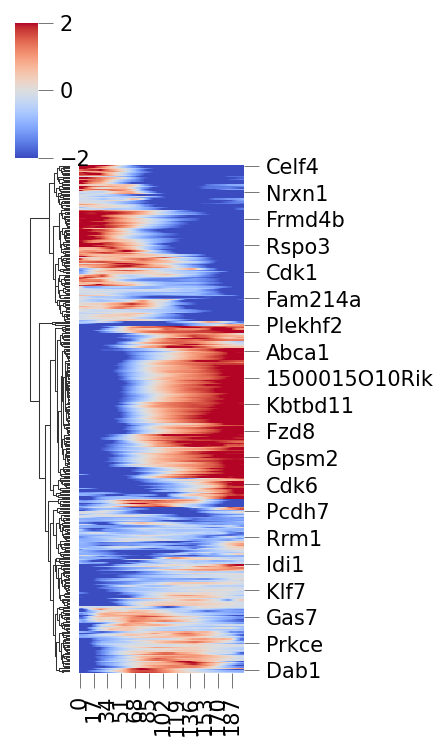

In [43]:
ratio = np.log2((damlb1_df_mmscale + .1)  / 
                ((exp_df_mmscale + .1) + (dam_df_mmscale + .1)))

cg = sns.clustermap(ratio, 
                    col_cluster=False, 
                    vmin=-2, 
                    vmax=2,
                    cmap='coolwarm', 
               figsize=(3,5),
)

In [44]:
reordered_ind = cg.dendrogram_row.reordered_ind[::-1]

In [45]:
_d = dict(zip(exp_df_mmscale.iloc[reordered_ind].index, np.arange(var_names.size)))

plot_var_names = np.array(['Eomes','Neurod4','Neurog2',
             'Pax6','Sox6','Ptn','Psat1','Npas3','Notch2',
             'Sox21','Gli3','Hopx','Sox9','Sox3','Vim','Neurod6','Ank2',
             'Nrp1','Ank3','Robo2','Gria2','Rbfox1','Robo1','Nav3','Satb2','Bcl11a',
             'Gpm6a','Mef2c','Nrp2','Nrn1','Sox11','Epha3','Tbr1','Plcb1','Slc17a6','Foxp2',
             'Negr1','Clstn2','Grin2b','Stmn4','Stmn2','Dpysl3','Gas2l3','Nde1','Slc1a3','Fabp7',
                  'Yap1','Cst3','Rest','Sema5a','Qk'
])
plot_var_names = plot_var_names[np.isin(plot_var_names, var_names)]

len(plot_var_names)

len(plot_var_names)

47

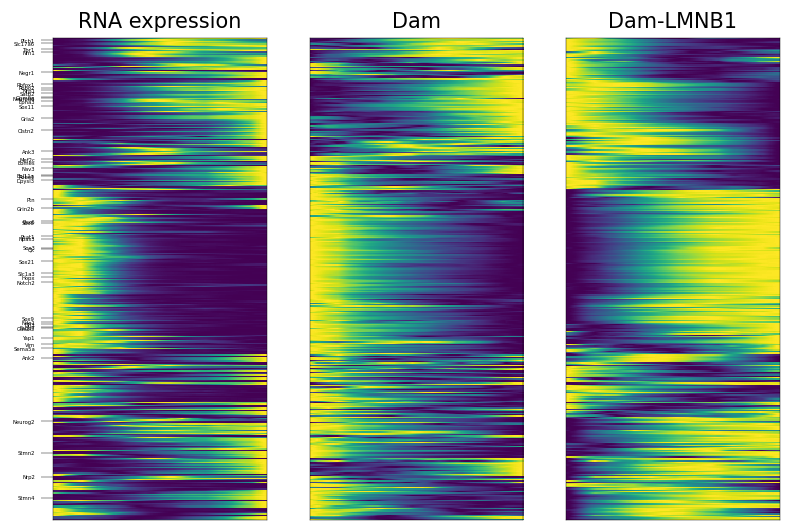

In [46]:
nrows, ncols = 1, 3
f, ax = plt.subplots(nrows=nrows, 
                     ncols=ncols, 
                     figsize=(2.5*ncols,5), 
                     gridspec_kw={'wspace':.2},
                     dpi=125
)

for i,df in enumerate([exp_df_mmscale,dam_df_mmscale,damlb1_df_mmscale]):
    ax[i].pcolorfast(df.iloc[reordered_ind].values, 
                     vmin=0,
                     vmax=1,
                     cmap='viridis' #rocket
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(['RNA expression','Dam','Dam-LMNB1'][i])

yticks = [_d[var] + .5 for var in plot_var_names]
ax[0].set_yticks(yticks)
_ = ax[0].set_yticklabels(plot_var_names, fontsize=3)

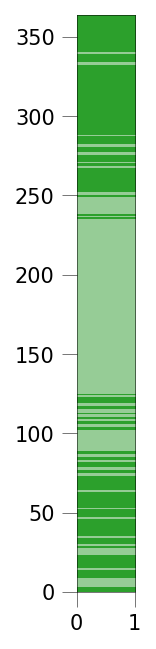

In [47]:
idx = (gene_class.set_index('Gene').loc[var_names[reordered_ind],'trend'] == 'activating').values.astype(int)

f, ax = plt.subplots(figsize=(.5,5))

ax.pcolorfast(idx.reshape(-1,1), cmap=cmap.from_list('',['#96cc96','#2ca02c']))

_Dam-Lamin B1_

In [48]:
bcs = anno_sub[(~anno_sub['monocle_pseudotime'].isna()) & (anno_sub['construct_flattened'] == 'Dam-LMNB1')].sort_values('monocle_pseudotime').index

adata_lb1 = sc.AnnData(adata[bcs].X, obs=adata[bcs].obs, var=adata[bcs].var)
adata_lb1.layers['count_abundance_genes_from_celseq2_data'] = adata[bcs].layers['count_abundance_genes_from_celseq2_data']
adata_lb1.layers['spliced'] = adata[bcs].layers['spliced']
adata_lb1.layers['unspliced'] = adata[bcs].layers['unspliced']
adata_lb1.layers['damid'] = adata[bcs].layers['damid']

adata_lb1.obsm['X_umap'] = adata_lb1.obs[['UMAP1','UMAP2']].values

adata_lb1

AnnData object with n_obs × n_vars = 2139 × 11350
    obs: 'limsid', 'indexnr', 'damid2_barcodenr', 'celseq2_barcodenr', 'iue', 'collection', 'embryo', 'construct', 'construct_flattened', 'n_genes_by_counts', 'total_counts', 'leiden', 'monocle_pseudotime', 'velocity_pseudotime', 'latent_time', 'UMAP1', 'UMAP2', 'cell_type', 'damid_signaltonoise', 'cellcycle_fraction', 'cycling', 'g1_fraction', 'g2m_fraction', 's_fraction', 'cellcycle_phase', 'dam_counts', 'damid'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'dispersions', 'highly_variable', 'monocle3_qvalue', 'in_lad_cf15', 'in_lad_cf20'
    obsm: 'X_umap'
    layers: 'count_abundance_genes_from_celseq2_data', 'spliced', 'unspliced', 'damid'

In [49]:
sc.tl.pca(adata_lb1, use_highly_variable=True, svd_solver='arpack', n_comps=100, random_state=0)

In [50]:
Z = harmonize(adata_lb1.obsm['X_pca'], adata_lb1.obs, batch_key = 'limsid', random_state=0)
adata_lb1.obsm['X_pca_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [51]:
scv.pp.moments(adata_lb1, add_layers=['count_abundance_genes_from_celseq2_data','damid'], 
               n_pcs=30, 
               n_neighbors=10, 
               use_rep='X_pca_harmony'
)

computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
--> added 
    'Mc' moments of count_abundance_genes_from_celseq2_data abundances (adata.layers)
--> added 
    'Md' moments of damid abundances (adata.layers)


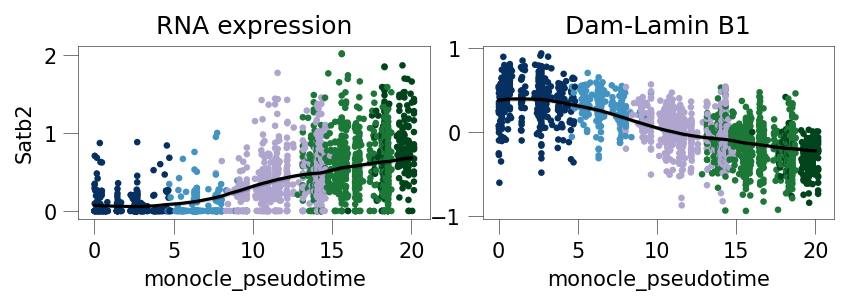

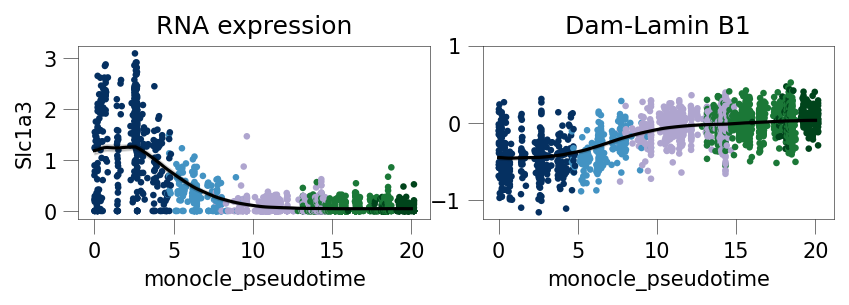

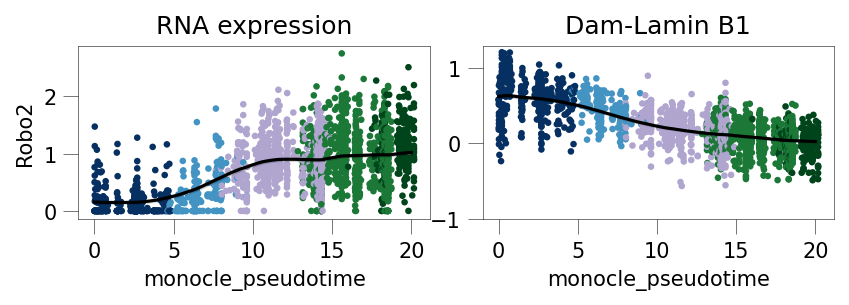

In [53]:
for var_name in ['Satb2','Slc1a3','Robo2']:
    f, ax = plt.subplots(1, 
                         2, 
                         figsize=(6.5,1.5), 
                         gridspec_kw={'wspace':.15},
    )

    #expression
    X = adata_lb1.obs['monocle_pseudotime']
    Mc = np.ravel(adata_lb1[:,var_name].layers['Mc'].toarray())
    hue = adata_lb1.obs['cell_type']

    sns.scatterplot(x=X, 
                    y=Mc, 
                    hue=hue, 
                    hue_order=adata.obs['cell_type'].cat.categories,
                    palette=adata.uns['cell_type_colors'],
                    lw=0, 
                    s=10, 
                    alpha=1,
                    legend=False,
                    ax=ax[0]
    )
    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Mc, 
                                    _RADIUS=2, 
                                    step=.2
    )
    ax[0].plot(xhat, 
               yhat, 
               color='k'
    )
    ax[0].fill_between(xhat, 
                       yhat-yhat_sem, 
                       yhat+yhat_sem, 
                       color='k', 
                       alpha=.15
    )


    #Dam-lb1
    X = adata_lb1.obs['monocle_pseudotime']
    Md = np.ravel(adata_lb1[:,var_name].layers['Md'].toarray())
    hue = adata_lb1.obs['cell_type']

    sns.scatterplot(x=X, 
                    y=Md, 
                    hue=hue, 
                    hue_order=adata.obs['cell_type'].cat.categories,
                    palette=adata.uns['cell_type_colors'],
                    lw=0, 
                    s=10, 
                    alpha=1,
                    legend=False,
                    ax=ax[1]
    )
    xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                    y=Md, 
                                    _RADIUS=2, 
                                    step=.2
    )
    ax[1].plot(xhat, 
               yhat, 
               color='k'
    )
    ax[1].fill_between(xhat, 
                       yhat-yhat_sem, 
                       yhat+yhat_sem, 
                       color='k', 
                       alpha=.15
    )
    #ax[1].set_ylim(top=min(2.1, ax[1].get_ylim()[1]))

    ax[0].set_ylabel(var_name)
    ax[1].set_yticks([-1,0,1])

    ax[0].set_title('RNA expression')
    ax[1].set_title('Dam-Lamin B1')